In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
historical_transaction_data = pd.read_csv("Datasets/Historical-transaction-data.csv")
store_info_data = pd.read_csv("Datasets/Store-info.csv")
test_df = pd.read_csv("Datasets/Testing-data.csv")

In [ ]:
historical_transaction_data.head()

In [ ]:
historical_transaction_data.dtypes

In [ ]:
historical_transaction_data["shop_id"].nunique()

In [ ]:
historical_transaction_data.isna().sum()

In [ ]:
historical_transaction_data.shape

In [ ]:
# Get the rows with quantity_sold has the value 0
historical_transaction_data.loc[historical_transaction_data["quantity_sold"] == 0]

In [ ]:
# plot the values of quantity_sold and shop_id
plt.figure(figsize=(20, 10))
sns.scatterplot(x="quantity_sold", y="shop_id", data=historical_transaction_data)


# Working with item_description feature


In [ ]:
historical_transaction_data["item_description"].unique()

In [ ]:
historical_transaction_data["item_description"].nunique()

In [3]:
train_df = historical_transaction_data.copy(deep=True)

In [ ]:
train_df.head()

In [4]:
train_df[["item_name", "item_quantity"]] = train_df["item_description"].str.rsplit(
    " ", n=1, expand=True
)

In [ ]:
train_df.head()

### Covert the values in the item_quantity to liters


In [5]:
def convert_to_liters(value):
    try:
        if value[-2:] == "ML":
            return float(value[:-2]) / 1000
        else:
            return float(value[:-1])
    except:
        return np.NaN

In [6]:
train_df["item_quantity_in_liters"] = train_df["item_quantity"].apply(
    lambda x: convert_to_liters(x)
)

In [ ]:
train_df["item_quantity_in_liters"].head()

### Drop the item_quantity column


In [ ]:
train_df.drop(["item_quantity"], axis=1, inplace=True)

In [ ]:
train_df.head()

### Drop the item_description column


In [ ]:
train_df.drop(["item_description"], axis=1, inplace=True)

In [ ]:
train_df.head()

# Working on customers interest


In [ ]:
train_df.head()

In [ ]:
train_df["customer_id"].nunique()

In [7]:
unique_customers = (
    train_df[["shop_id", "customer_id"]].groupby("shop_id")["customer_id"].nunique()
)

In [8]:
unique_customers_df = unique_customers.to_frame().reset_index()

In [10]:
unique_customers_df.head()

,shop_id,customer_id
0,SHOP001,1118
1,SHOP002,2577
2,SHOP003,2064
3,SHOP004,1744
4,SHOP005,2203


In [9]:
unique_customers_df = unique_customers_df.rename(
    columns={"customer_id": "unique_customers"}
)

In [10]:
unique_customers_df.head()

,shop_id,unique_customers
0,SHOP001,1118
1,SHOP002,2577
2,SHOP003,2064
3,SHOP004,1744
4,SHOP005,2203


In [11]:
customer_info_df = pd.merge(unique_customers_df, store_info_data, on="shop_id")

In [12]:
customer_info_df.head()

,shop_id,unique_customers,shop_area_sq_ft,shop_profile
0,SHOP001,1118,580,Low
1,SHOP002,2577,637,NaN
2,SHOP003,2064,810,High
3,SHOP004,1744,516,Low
4,SHOP005,2203,617,Low


In [13]:
store_info_data = customer_info_df.copy(deep=True)

In [14]:
store_info_data.head()

,shop_id,unique_customers,shop_area_sq_ft,shop_profile
0,SHOP001,1118,580,Low
1,SHOP002,2577,637,NaN
2,SHOP003,2064,810,High
3,SHOP004,1744,516,Low
4,SHOP005,2203,617,Low


In [ ]:

cur_temp_df = store_info_data.copy(deep=True)
plt.figure(figsize=(20, 10))
# sns pair plot to show the hue with shop_profile and unique_customers in cur_temp_df
sns.pairplot(cur_temp_df, hue="shop_profile", vars=["unique_customers"])

In [ ]:
# pivot_table = pd.pivot_table(cur_temp_df, index='shop_id', columns='shop_profile', values='unique_customers')

# create a bar plot for each shop_id with the shop_profile categories colored differently
# pivot_table.plot(kind='bar', stacked=True)

# add axis labels and a title
# plt.xlabel('Shop ID')
# plt.ylabel('Number of Unique Customers')
# plt.title('Unique Customers per Shop by Shop Profile')

plt.scatter(
    cur_temp_df[cur_temp_df["shop_profile"] == "High"]["shop_id"],
    cur_temp_df[cur_temp_df["shop_profile"] == "High"]["unique_customers"],
    color="red",
)
plt.scatter(
    cur_temp_df[cur_temp_df["shop_profile"] == "Moderate"]["shop_id"],
    cur_temp_df[cur_temp_df["shop_profile"] == "Moderate"]["unique_customers"],
    color="blue",
)
plt.scatter(
    cur_temp_df[cur_temp_df["shop_profile"] == "Low"]["shop_id"],
    cur_temp_df[cur_temp_df["shop_profile"] == "Low"]["unique_customers"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Fix Quantity


In [15]:
min_prices = (
    train_df[["item_name", "item_price"]]
    .groupby("item_name")["item_price"]
    .min()
    .to_dict()
)

# if item_name is in min_prices, then use min_prices[item_name] to calculate the quantity sold or use the existing quantity sold


def calculate_quantity_sold(row):
    if row["item_name"] in min_prices and row["quantity_sold"] == 0:
        return row["item_price"] // min_prices[row["item_name"]]
    elif row['quantity_sold'] == 0:
        return 1
    else:
        return row["quantity_sold"]


train_df["quantity_sold"] = train_df.apply(
    lambda row: calculate_quantity_sold(row), axis=1
)

In [ ]:
train_df["customer_id"].nunique()

In [ ]:
train_df.head()

# Handling the outliers

<AxesSubplot:xlabel='quantity_sold', ylabel='shop_id'>

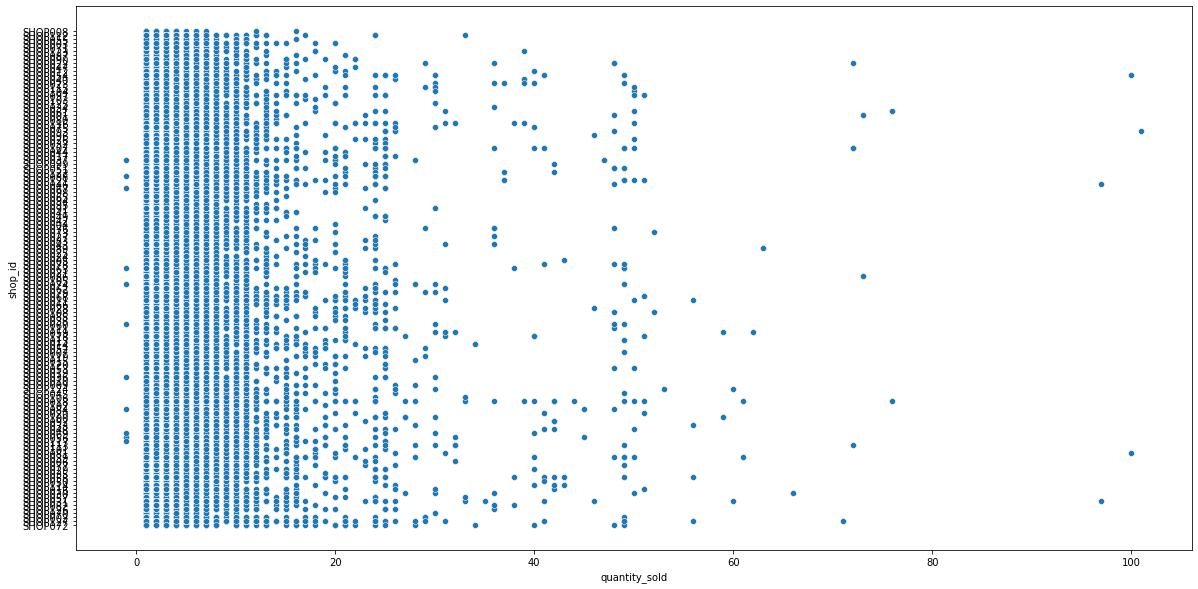

In [18]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="quantity_sold", y="shop_id", data=train_df)

In [ ]:
train_df['quantity_sold'].describe()

In [ ]:
train_df['quantity_sold'].quantile(0.995)

In [ ]:
train_df.shape

In [ ]:
train_df.loc[train_df['quantity_sold'] > 10]

In [16]:
# get the rows where the quantity_sold is greater than 13 (0.995 quantile)
# drop the rows from the train_df where quantity_sold is greater than 13
# train_df.drop(train_df[train_df['quantity_sold'] > 10].index, inplace=True)
train_df.drop(train_df[train_df['quantity_sold'] > 40].index, inplace=True)
# train_df.loc[train_df['quantity_sold'] > 13]


In [ ]:
train_df.shape

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="quantity_sold", y="shop_id", data=train_df)

# Working with Sales


In [ ]:
train_df.head()

In [17]:
tot_sales = train_df[["shop_id", "item_price"]].groupby("shop_id")["item_price"].sum()

In [18]:
tot_sales_df = tot_sales.to_frame().reset_index()
tot_sales_df.head()

,shop_id,item_price
0,SHOP001,426425
1,SHOP002,1088455
2,SHOP003,769685
3,SHOP004,711050
4,SHOP005,840265


In [19]:
store_info_data.head()

,shop_id,unique_customers,shop_area_sq_ft,shop_profile
0,SHOP001,1118,580,Low
1,SHOP002,2577,637,NaN
2,SHOP003,2064,810,High
3,SHOP004,1744,516,Low
4,SHOP005,2203,617,Low


In [20]:
tot_sales_df = tot_sales_df.rename(columns={"item_price": "total_sales"})

In [24]:
tot_sales_df.head()

,shop_id,total_sales
0,SHOP001,426425
1,SHOP002,1088455
2,SHOP003,769685
3,SHOP004,711050
4,SHOP005,840265


In [21]:
store_info_df = pd.merge(tot_sales_df, store_info_data, on="shop_id")

In [22]:
store_info_df.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile
0,SHOP001,426425,1118,580,Low
1,SHOP002,1088455,2577,637,NaN
2,SHOP003,769685,2064,810,High
3,SHOP004,711050,1744,516,Low
4,SHOP005,840265,2203,617,Low


In [23]:
store_info_data = store_info_df.copy(deep=True)

In [24]:
store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile
0,SHOP001,426425,1118,580,Low
1,SHOP002,1088455,2577,637,NaN
2,SHOP003,769685,2064,810,High
3,SHOP004,711050,1744,516,Low
4,SHOP005,840265,2203,617,Low


In [ ]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_area_sq_ft"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_area_sq_ft"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_area_sq_ft"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Work on date


In [25]:
# Seperate date into day, month, year, time and day of week
train_df["transaction_date"] = pd.to_datetime(train_df["transaction_date"])
train_df["transaction_day"] = train_df["transaction_date"].dt.day
train_df["transaction_month"] = train_df["transaction_date"].dt.month
train_df["transaction_year"] = train_df["transaction_date"].dt.year
train_df["transaction_time"] = train_df["transaction_date"].dt.time
train_df["transaction_day_of_week"] = train_df["transaction_date"].dt.dayofweek

train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_year,transaction_time,transaction_day_of_week
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,2021,00:00:00,5
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,2021,00:00:00,6
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,2021,00:00:00,0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,2021,00:00:00,0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,2021,00:00:00,5


In [26]:
# Print the number of unique values in each column
for col in train_df.columns:
    print(col, train_df[col].nunique())

item_description 37
transaction_date 62
invoice_id 343274
customer_id 191601
shop_id 124
item_price 186
quantity_sold 41
item_name 21
item_quantity 6
item_quantity_in_liters 6
transaction_day 31
transaction_month 3
transaction_year 1
transaction_time 1
transaction_day_of_week 7


In [27]:
# Remove time and year
train_df.drop(["transaction_time", "transaction_year"], axis=1, inplace=True)

In [32]:
train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,5
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,6
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,5


# Average customers per month

In [28]:
# Average Customers per Month per Shop
avg_customers_per_month = train_df.groupby(['shop_id', 'transaction_month'])['customer_id'].nunique().reset_index()
avg_customers_per_month = avg_customers_per_month.groupby('shop_id')['customer_id'].mean().reset_index()
avg_customers_per_month = avg_customers_per_month.rename(columns={'customer_id': 'avg_customers_per_month'})

avg_customers_per_month.head()

# Merge with store info
store_info_data = pd.merge(store_info_data, avg_customers_per_month, on="shop_id")
store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month
0,SHOP001,426425,1118,580,Low,450.000000
1,SHOP002,1088455,2577,637,NaN,1038.333333
2,SHOP003,769685,2064,810,High,820.666667
3,SHOP004,711050,1744,516,Low,729.333333
4,SHOP005,840265,2203,617,Low,909.333333


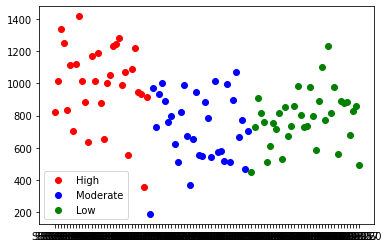

In [29]:
temp_df = store_info_data[store_info_data["shop_profile"] == "High"]
plt.scatter(
    temp_df["shop_id"],
    temp_df["avg_customers_per_month"],
    color="red",
)
temp_df = store_info_data[store_info_data["shop_profile"] == "Moderate"]
plt.scatter(
    temp_df["shop_id"],
    temp_df["avg_customers_per_month"],
    color="blue",
)
temp_df = store_info_data[store_info_data["shop_profile"] == "Low"]
plt.scatter(
    temp_df["shop_id"],
    temp_df["avg_customers_per_month"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

plt.show()

# Get the total sales for 12th month

In [30]:
train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,5
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,6
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,5


In [31]:
# create a new column called total_sales_december
# group by shop_id and month and sum the item_price
# if month is 12, then add the item_price to the total_sales_december column
# else add 0 to the total_sales_december column

month_shop_sales = train_df[train_df["transaction_month"] == 12].reset_index()

In [32]:
month_shop_sales.head()

,index,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week
0,0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.5,11,12,5
1,2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.5,13,12,0
2,3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.0,13,12,0
3,17,LEMONADE 500ML,2021-12-01 00:00:00+00:00,7946.0,ZYJ7,SHOP112,200,3,LEMONADE,500ML,0.5,1,12,2
4,18,FIT O ORANGE 1L,2021-12-02 00:00:00+00:00,8258.0,JM5Q,SHOP112,290,2,FIT O ORANGE,1L,1.0,2,12,3


In [33]:
december_sales = month_shop_sales.groupby(["shop_id"])['item_price'].sum().reset_index()
december_sales = pd.DataFrame(december_sales)
december_sales.head()

,shop_id,item_price
0,SHOP001,154660
1,SHOP002,392665
2,SHOP003,252225
3,SHOP004,247850
4,SHOP005,245570


In [34]:
december_sales = december_sales.rename(columns={'item_price': 'december_sales'})

In [35]:
december_sales.head()

,shop_id,december_sales
0,SHOP001,154660
1,SHOP002,392665
2,SHOP003,252225
3,SHOP004,247850
4,SHOP005,245570


In [36]:
store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month
0,SHOP001,426425,1118,580,Low,450.000000
1,SHOP002,1088455,2577,637,NaN,1038.333333
2,SHOP003,769685,2064,810,High,820.666667
3,SHOP004,711050,1744,516,Low,729.333333
4,SHOP005,840265,2203,617,Low,909.333333


In [37]:
store_info_data = pd.merge(store_info_data, december_sales, on="shop_id")

store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales
0,SHOP001,426425,1118,580,Low,450.000000,154660
1,SHOP002,1088455,2577,637,NaN,1038.333333,392665
2,SHOP003,769685,2064,810,High,820.666667,252225
3,SHOP004,711050,1744,516,Low,729.333333,247850
4,SHOP005,840265,2203,617,Low,909.333333,245570


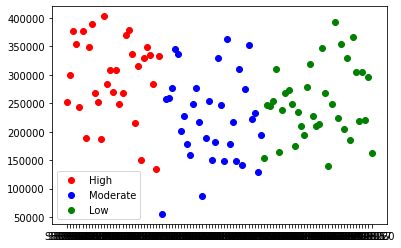

In [38]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["december_sales"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["december_sales"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["december_sales"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Work on most popular beverage


In [39]:
# Get most popular item per shop

item_counts = train_df.groupby(["shop_id", "item_name"])["quantity_sold"].sum()

most_popular_items = item_counts.groupby("shop_id").idxmax().reset_index()
most_popular_items.columns = ["shop_id", "most_sold_item"]
most_popular_items["most_sold_item"] = most_popular_items["most_sold_item"].str[1]

most_popular_items.count()

shop_id           124
most_sold_item    124
dtype: int64

In [40]:
# Merge with store info
store_info_data = pd.merge(store_info_data, most_popular_items, on="shop_id")

store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item
0,SHOP001,426425,1118,580,Low,450.000000,154660,GINGER BEER
1,SHOP002,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA
2,SHOP003,769685,2064,810,High,820.666667,252225,CREAM SODA
3,SHOP004,711050,1744,516,Low,729.333333,247850,GINGER BEER
4,SHOP005,840265,2203,617,Low,909.333333,245570,GINGER BEER


# Average time between orders


In [41]:
train_df_ = train_df.copy(deep=True)

train_df_.sort_values(["customer_id", "transaction_date"], inplace=True)

train_df_

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week
452281,ORANGE BARLEY 1.5L,2021-10-16 00:00:00+00:00,370560.0,0.00E+00,SHOP010,440,2,ORANGE BARLEY,1.5L,1.5,16,10,5
308101,ORANGE BARLEY 1.5L,2021-10-26 00:00:00+00:00,61463.0,0.00E+00,SHOP034,880,5,ORANGE BARLEY,1.5L,1.5,26,10,1
454752,FIT O ORANGE 1L,2021-10-27 00:00:00+00:00,1328902.0,0.00E+00,SHOP111,270,2,FIT O ORANGE,1L,1.0,27,10,2
333814,SODA 1L,2021-10-29 00:00:00+00:00,668008.0,0.00E+00,SHOP081,110,2,SODA,1L,1.0,29,10,4
333815,GINGER BEER 1L,2021-10-29 00:00:00+00:00,668008.0,0.00E+00,SHOP081,150,2,GINGER BEER,1L,1.0,29,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202042,SODA PET 1.5L,2021-11-21 00:00:00+00:00,213333.0,ZZZW,SHOP073,160,2,SODA PET,1.5L,1.5,21,11,6
202043,GINGER BEER 1.5L,2021-11-21 00:00:00+00:00,213333.0,ZZZW,SHOP073,220,1,GINGER BEER,1.5L,1.5,21,11,6
234007,GINGER BEER 1.5L,2021-11-25 00:00:00+00:00,3233435.0,ZZZW,SHOP074,220,2,GINGER BEER,1.5L,1.5,25,11,3
463571,SODA PET 1.5L,2021-12-04 00:00:00+00:00,294745.0,ZZZW,SHOP074,160,1,SODA PET,1.5L,1.5,4,12,5


In [42]:
train_df_["time_since_last_purchase"] = (
    train_df_.groupby("customer_id")["transaction_date"].diff().dt.days
)
train_df_

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week,time_since_last_purchase
452281,ORANGE BARLEY 1.5L,2021-10-16 00:00:00+00:00,370560.0,0.00E+00,SHOP010,440,2,ORANGE BARLEY,1.5L,1.5,16,10,5,NaN
308101,ORANGE BARLEY 1.5L,2021-10-26 00:00:00+00:00,61463.0,0.00E+00,SHOP034,880,5,ORANGE BARLEY,1.5L,1.5,26,10,1,10.0
454752,FIT O ORANGE 1L,2021-10-27 00:00:00+00:00,1328902.0,0.00E+00,SHOP111,270,2,FIT O ORANGE,1L,1.0,27,10,2,1.0
333814,SODA 1L,2021-10-29 00:00:00+00:00,668008.0,0.00E+00,SHOP081,110,2,SODA,1L,1.0,29,10,4,2.0
333815,GINGER BEER 1L,2021-10-29 00:00:00+00:00,668008.0,0.00E+00,SHOP081,150,2,GINGER BEER,1L,1.0,29,10,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202042,SODA PET 1.5L,2021-11-21 00:00:00+00:00,213333.0,ZZZW,SHOP073,160,2,SODA PET,1.5L,1.5,21,11,6,NaN
202043,GINGER BEER 1.5L,2021-11-21 00:00:00+00:00,213333.0,ZZZW,SHOP073,220,1,GINGER BEER,1.5L,1.5,21,11,6,0.0
234007,GINGER BEER 1.5L,2021-11-25 00:00:00+00:00,3233435.0,ZZZW,SHOP074,220,2,GINGER BEER,1.5L,1.5,25,11,3,4.0
463571,SODA PET 1.5L,2021-12-04 00:00:00+00:00,294745.0,ZZZW,SHOP074,160,1,SODA PET,1.5L,1.5,4,12,5,9.0


In [43]:
avg_time_between_purchases = (
    train_df_.groupby("shop_id")["time_since_last_purchase"].mean().reset_index()
)

In [44]:
# Merge with store info
store_info_data = pd.merge(store_info_data, avg_time_between_purchases, on="shop_id")
store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase
0,SHOP001,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467
1,SHOP002,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651
2,SHOP003,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475
3,SHOP004,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707
4,SHOP005,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329


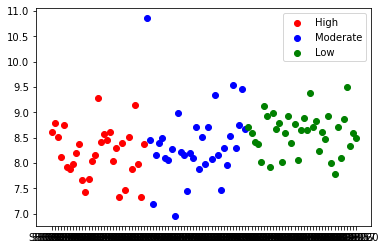

In [45]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["time_since_last_purchase"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["time_since_last_purchase"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["time_since_last_purchase"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Weekend Weekday Sales

In [46]:
train_df_2 = train_df_.copy(deep=True)

# Weekend boolean column
train_df_2['weekend'] = train_df_2['transaction_day_of_week'].apply(lambda x: 1 if x >= 4 else 0)

weekend_sales = train_df_2[train_df_2['weekend'] == 1].groupby('shop_id')['item_price'].sum().reset_index()
weekend_sales = weekend_sales.rename(columns={'item_price': 'weekend_sales'})

weekday_sales = train_df_2[train_df_2['weekend'] == 0].groupby('shop_id')['item_price'].sum().reset_index()
weekday_sales = weekday_sales.rename(columns={'item_price': 'weekday_sales'})


store_info_data = pd.merge(store_info_data, weekend_sales, on="shop_id")
store_info_data = pd.merge(store_info_data, weekday_sales, on="shop_id")

store_info_data.head()

,shop_id,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales
0,SHOP001,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945
1,SHOP002,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975
2,SHOP003,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450
3,SHOP004,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560
4,SHOP005,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085


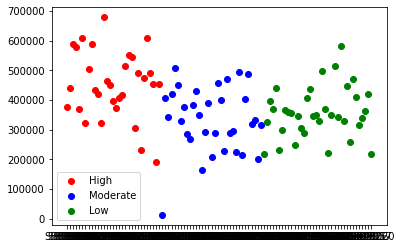

In [47]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["weekday_sales"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["weekday_sales"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["weekday_sales"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Working with number of customers that came more than once


In [48]:
# Get the customers that came more than once to the corresponding shop
# number of customers that came more than once
customers_that_came_more_than_once = (
    train_df_.groupby("shop_id")["customer_id"]
    .apply(lambda x: x[x.duplicated()].nunique())
    .reset_index()
)
# customers_that_came_more_than_once = train_df_.groupby('shop_id')['customer_id'].apply(lambda x: x[x.duplicated()].unique()).reset_index()

In [49]:
customers_that_came_more_than_once.head()
customers_that_came_more_than_once = customers_that_came_more_than_once.rename(
    columns={"customer_id": "came_more_than_once"}
)
customer_visit_df = pd.merge(
    customers_that_came_more_than_once, store_info_data, on="shop_id"
)
store_info_data = customer_visit_df.copy(deep=True)

In [50]:
store_info_data.head()

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085


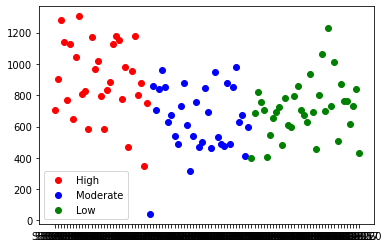

In [51]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["came_more_than_once"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["came_more_than_once"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["came_more_than_once"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Total quantity sold per shop

In [52]:
total_units_sold = train_df.groupby("shop_id")["quantity_sold"].sum().reset_index()
total_units_sold = total_units_sold.rename(columns={'quantity_sold': 'total_units_sold'})

# Merge with store info
store_info_data = pd.merge(store_info_data, total_units_sold, on="shop_id")
store_info_data

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP123,410,412440,1159,735,Moderate,469.666667,128365,GINGER BEER,9.452362,210375,202065,3908
120,SHOP124,877,935575,2281,606,High,934.000000,284135,GINGER BEER,7.973333,481565,454010,9118
121,SHOP125,346,395845,893,1028,High,355.000000,133955,GINGER BEER,7.329644,204655,191190,4438
122,SHOP126,598,651845,1769,328,Moderate,705.666667,195130,CREAM SODA,8.665234,336090,315755,6638


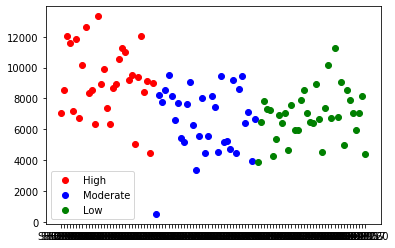

In [53]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["total_units_sold"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["total_units_sold"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["total_units_sold"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Working with Invoice

In [54]:
store_info_data.head()

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839


In [55]:
train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,5
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,6
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,5


In [56]:
# group by customer_id and invoice_id and get the total price
customer_total_spent = train_df.groupby(["shop_id", "invoice_id"])['item_price'].sum().reset_index()
# convert customer_total_spent to dataframe
customer_total_spent = pd.DataFrame(customer_total_spent)

In [57]:
customer_total_spent.head()

,shop_id,invoice_id,item_price
0,SHOP001,71216.0,220
1,SHOP001,71241.0,220
2,SHOP001,71244.0,520
3,SHOP001,71249.0,220
4,SHOP001,71278.0,130


In [58]:
# group by shop_id and get the number of invoice_ids in each shop
customer_total_orders = train_df.groupby("shop_id")["invoice_id"].nunique().reset_index()
customer_total_orders = pd.DataFrame(customer_total_orders)
customer_total_orders.head()

,shop_id,invoice_id
0,SHOP001,1535
1,SHOP002,3769
2,SHOP003,2867
3,SHOP004,2641
4,SHOP005,3183


In [59]:
customer_total_orders = customer_total_orders.rename(columns={'invoice_id': 'total_invoices'})

# Merge with store info
store_info_data = pd.merge(store_info_data, customer_total_orders, on="shop_id")
store_info_data

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold,total_invoices
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892,1535
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644,3769
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051,2867
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502,2641
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839,3183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP123,410,412440,1159,735,Moderate,469.666667,128365,GINGER BEER,9.452362,210375,202065,3908,1608
120,SHOP124,877,935575,2281,606,High,934.000000,284135,GINGER BEER,7.973333,481565,454010,9118,3245
121,SHOP125,346,395845,893,1028,High,355.000000,133955,GINGER BEER,7.329644,204655,191190,4438,1274
122,SHOP126,598,651845,1769,328,Moderate,705.666667,195130,CREAM SODA,8.665234,336090,315755,6638,2563


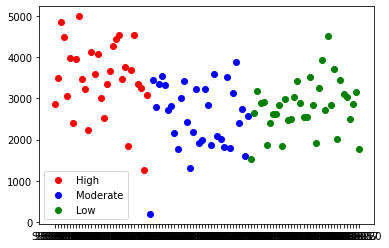

In [60]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["total_invoices"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["total_invoices"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["total_invoices"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

# Average shop earning for all three months

In [61]:
# group by shop_id and get the average total price
shop_average_earn = customer_total_spent.groupby("shop_id")['item_price'].mean().reset_index()

In [62]:
shop_average_earn = pd.DataFrame(shop_average_earn)

In [63]:
shop_average_earn.head()

,shop_id,item_price
0,SHOP001,271.198697
1,SHOP002,286.446007
2,SHOP003,265.291245
3,SHOP004,265.566073
4,SHOP005,257.075086


In [64]:
shop_average_earn = shop_average_earn.rename(columns={'item_price': 'average_shop_earning'})

# Merge with store info
store_info_data = pd.merge(store_info_data, shop_average_earn, on="shop_id")
store_info_data

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold,total_invoices,average_shop_earning
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892,1535,271.198697
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644,3769,286.446007
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051,2867,265.291245
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502,2641,265.566073
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839,3183,257.075086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP123,410,412440,1159,735,Moderate,469.666667,128365,GINGER BEER,9.452362,210375,202065,3908,1608,251.346393
120,SHOP124,877,935575,2281,606,High,934.000000,284135,GINGER BEER,7.973333,481565,454010,9118,3245,282.169492
121,SHOP125,346,395845,893,1028,High,355.000000,133955,GINGER BEER,7.329644,204655,191190,4438,1274,289.642857
122,SHOP126,598,651845,1769,328,Moderate,705.666667,195130,CREAM SODA,8.665234,336090,315755,6638,2563,250.507218


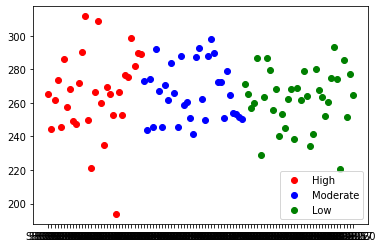

In [65]:
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "High"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "High"]["average_shop_earning"],
    color="red",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Moderate"]["average_shop_earning"],
    color="blue",
)
plt.scatter(
    store_info_data[store_info_data["shop_profile"] == "Low"]["shop_id"],
    store_info_data[store_info_data["shop_profile"] == "Low"]["average_shop_earning"],
    color="green",
)
plt.legend(["High", "Moderate", "Low"])

# show the plot
plt.show()

In [66]:
store_info_data.head()

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold,total_invoices,average_shop_earning
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892,1535,271.198697
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644,3769,286.446007
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051,2867,265.291245
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502,2641,265.566073
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839,3183,257.075086


# Get the total amount of liters of beverage sold

In [67]:
train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,5
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,6
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,5


In [68]:
train_df['total_quantity'] = train_df['quantity_sold'] * train_df['item_quantity_in_liters']
train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week,total_quantity
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,5,3.0
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,6,3.0
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,0,1.0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,0,2.0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,5,0.9


In [69]:
total_liters_of_beverage_sold = train_df.groupby("shop_id")["total_quantity"].sum().reset_index()
total_liters_of_beverage_sold = pd.DataFrame(total_liters_of_beverage_sold)
total_liters_of_beverage_sold.head()

,shop_id,total_quantity
0,SHOP001,3696.90
1,SHOP002,9282.24
2,SHOP003,6608.94
3,SHOP004,6164.86
4,SHOP005,6866.48


In [70]:
total_liters_of_beverage_sold = total_liters_of_beverage_sold.rename(columns={'total_quantity': 'total_liters_of_beverage_sold'})
total_liters_of_beverage_sold.head()

,shop_id,total_liters_of_beverage_sold
0,SHOP001,3696.90
1,SHOP002,9282.24
2,SHOP003,6608.94
3,SHOP004,6164.86
4,SHOP005,6866.48


In [71]:
store_info_data = pd.merge(store_info_data, total_liters_of_beverage_sold, on="shop_id")
store_info_data.head()

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold,total_invoices,average_shop_earning,total_liters_of_beverage_sold
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892,1535,271.198697,3696.90
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644,3769,286.446007,9282.24
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051,2867,265.291245,6608.94
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502,2641,265.566073,6164.86
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839,3183,257.075086,6866.48


In [72]:
store_info_data.head()

,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold,total_invoices,average_shop_earning,total_liters_of_beverage_sold
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892,1535,271.198697,3696.90
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644,3769,286.446007,9282.24
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051,2867,265.291245,6608.94
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502,2641,265.566073,6164.86
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839,3183,257.075086,6866.48


# Copying to a new dataframe before scaling

In [ ]:
temp_df_1 = store_info_data.copy(deep=True)

In [ ]:
temp_df_1.drop(["most_sold_item"], axis=1, inplace=True)

In [ ]:
historical_transaction_data.head()

In [ ]:
temp_df_1["shop_area_sq_ft"].describe()

In [ ]:
temp_df_1.describe()

In [ ]:
temp_df_1["uniq_cust_persqft"] = temp_df_1["unique_customers"] / temp_df_1["shop_area_sq_ft"]

# Splitting out train and test data


In [ ]:
test = temp_df_1[temp_df_1["shop_profile"].isnull()]
train = temp_df_1[temp_df_1["shop_profile"].notnull()]

In [ ]:
train_x = train.drop(["shop_profile"], axis=1).reset_index(drop=True)
train_y = train["shop_profile"].reset_index(drop=True)

test_x = test.drop(["shop_profile"], axis=1).reset_index(drop=True)

In [ ]:
train_x.head()

In [ ]:
test_x.head()

In [ ]:
train_x.columns

In [ ]:
scaling_columns = list(train_x.columns)
scaling_columns.remove("shop_id")

# Scale the data


In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

train_x[scaling_columns] = min_max_scaler.fit_transform(train_x[scaling_columns])
# scaled_train_df = min_max_scaler.fit_transform(train)
# scaled_train_df = pd.DataFrame(scaled_train_df, columns=train.columns)

test_x[scaling_columns] = min_max_scaler.transform(test_x[scaling_columns])

# scaled_test_df = min_max_scaler.transform(test_x)
# scaled_test_df = pd.DataFrame(scaled_test_df, columns=test.columns)

In [ ]:
train_x.head()

# Encode the data of shop_profile


In [ ]:
mapping = {"Low": 0, "Moderate": 1, "High": 2}
train_y = train_y.replace(mapping)

In [ ]:
train_y.head()

# Split Test and Train


In [ ]:
train_dataframe = pd.concat([train_x, train_y], axis=1)
train_dataframe.head()

In [ ]:
train_dataframe.drop(["shop_id"], axis=1, inplace=True)

In [ ]:
test_dataframe = test_x.copy(deep=True)

In [ ]:
test_dataframe.drop(["shop_id"], axis=1, inplace=True)

In [ ]:
corr_matrix = train_dataframe.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .5})

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_dataframe.drop("shop_profile", axis=1),
    train_dataframe["shop_profile"],
    test_size=0.2,
    random_state=0,
)

# 1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

In [ ]:
# get the shop ids of test_x in a separate dataframe
test_shop_ids = test_x[["shop_id"]].reset_index(drop=True)
test_shop_ids.head()

In [ ]:
train_x.drop(["shop_id"], axis=1, inplace=True)
test_x.drop(["shop_id"], axis=1, inplace=True)

In [ ]:
test_x.head()

# 2. Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

In [ ]:
importances = model.feature_importances_

# Visualize feature importances using a bar chart
plt.bar(X_train.columns[:], importances)
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
X_train.columns

In [ ]:
important_features = [
    "unique_customers",
    "shop_area_sq_ft",
    "time_since_last_purchase",
    "avg_customers_per_month",
]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

# 3. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:


train_x.describe()

In [ ]:
important_features = [
    # "unique_customers",
    # "shop_area_sq_ft",
    "time_since_last_purchase",
    "avg_customers_per_month",
    "uniq_cust_persqft"
]

# 4. Support Vector Machines

## Using Cross validation 

In [ ]:
train_x_new = train_x.copy(deep=True)
test_x_new = test_x.copy(deep=True)

In [ ]:
train_x_new = train_x_new[important_features]
test_x_new = test_x_new[important_features]

In [ ]:
train_y_new = train_y.copy(deep=True)

In [ ]:
train_x_new.shape

In [ ]:
from sklearn.model_selection import StratifiedKFold

from sklearn import svm

#Create a svm Classifier
model = svm.SVC(kernel='poly', C=5, random_state=0)

skf = StratifiedKFold(n_splits=5, shuffle=False)

accuracy_scores = []
f_scores = []

for train_index, test_index in skf.split(train_x_new, train_y_new):
    X_train, X_test = train_x_new.iloc[train_index], train_x_new.iloc[test_index]
    y_train, y_test = train_y_new.iloc[train_index], train_y_new.iloc[test_index]
    
    # fit your model on the training set
    #Train the model using the training sets
    model.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = model.predict(X_test)
    
    # calculate the accuracy score
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    # calculate the f1 score
    f_scores.append(f1_score(y_test, y_pred, average='macro'))

mean_accuracy_score = np.mean(accuracy_scores)
mean_f1_score = np.mean(f_scores)

print("Accuracy Score: {:.2f}%".format(mean_accuracy_score*100))
print("F1 score: {:.2f}%".format(mean_f1_score*100))

In [ ]:
accuracy_scores

In [ ]:
f_scores

In [ ]:
from sklearn.model_selection import train_test_split

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    train_dataframe.drop("shop_profile", axis=1),
    train_dataframe["shop_profile"],
    test_size=0.2,
    random_state=0,
)

In [ ]:
X_train_new = X_train_new[important_features]
X_test_new = X_test_new[important_features]

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=20, random_state=0)

#Train the model using the training sets
clf.fit(X_train_new, y_train_new)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)

f1 = f1_score(y_test_new, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test_new, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C=12, random_state=0, degree=5)

#Train the model using the training sets
clf.fit(X_train_new, y_train_new)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)

f1 = f1_score(y_test_new, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test_new, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C=12, random_state=0, degree=5)

#Train the model using the training sets
clf.fit(X_train_new, y_train_new)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)

f1 = f1_score(y_test_new, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test_new, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
X_train = X_train[important_features]
X_test = X_test[important_features]

In [ ]:
X_test.head()

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=5, random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=1, random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=5, random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=4, random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C=1, random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C=10, random_state=1)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C=1, random_state=1, break_ties=True, probability=True)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('F1 score:', f1)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy: {:.2f}%".format(accuracy))

# Final

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(train_x, train_y)

y_pred = model.predict(test_x)
y_pred

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

LR_model = LogisticRegression()
LR_model.fit(train_x, train_y)
y_pred = LR_model.predict(test_x)

# f1 = f1_score(y_test, y_pred, average='macro')

# print('F1 score:', f1)
y_pred

## Trying out with new features

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=5, random_state=0)

train_x_try = train_x[important_features]
test_x_try = test_x[important_features]

#Train the model using the training sets
clf.fit(train_x_try, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test_x_try)

y_pred = pd.DataFrame(y_pred, columns=["shop_profile"])
y_pred.head()

In [ ]:
y_pred["shop_profile"] = y_pred["shop_profile"].map({0: "Low", 1: "Moderate", 2: "High"})
y_pred.head()

In [ ]:
sample_try = pd.concat([test_shop_ids, y_pred], axis=1)
sample_try.head(24)

In [ ]:
test_df.head()

In [ ]:
test_try = pd.merge(test_df, sample_try, on="shop_id", how="left")
test_try.head(24)
test_try.to_csv("test_try.csv", index=False)

# Sample Try

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=5, random_state=0)

train_x_try = train_x[important_features]
test_x_try = test_x[important_features]

#Train the model using the training sets
clf.fit(train_x_try, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test_x_try)

y_pred = pd.DataFrame(y_pred, columns=["shop_profile"])

y_pred["shop_profile"] = y_pred["shop_profile"].map({0: "Low", 1: "Moderate", 2: "High"})

sample_try = pd.concat([test_shop_ids, y_pred], axis=1)

test_try = pd.merge(test_df["shop_id"], sample_try, on="shop_id", how="left")
test_try.to_csv("test_try_v2.csv", index=False)

# Submission 1 for 26-04-2023

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', C=4, random_state=0)

#Train the model using the training sets
clf.fit(train_x, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test_x)

In [ ]:
# make y_pred a dataframe
y_pred = pd.DataFrame(y_pred, columns=["shop_profile"])
y_pred.head()

In [ ]:
# map the values back to their original values
y_pred["shop_profile"] = y_pred["shop_profile"].map({0: "Low", 1: "Moderate", 2: "High"})
y_pred.head()

### New predictions

In [ ]:
submission3 = pd.concat([test_shop_ids, y_pred], axis=1)
submission3.head(24)

In [ ]:
test_df.drop(["shop_profile"], axis=1, inplace=True)

In [ ]:
final_sub = pd.merge(test_df, submission3, on="shop_id", how="left")
final_sub.head(24)

In [ ]:
# write submssion3 to submission3.csv
final_sub.to_csv("submission_final_26.csv", index=False)

### 25-04-2023

In [ ]:
# merge y_pred with test_shop_ids
test_shop_ids = pd.concat([test_shop_ids, y_pred], axis=1)
test_shop_ids.head(24)

In [ ]:
# concatenate test_data with test_shop_ids on shop_id
test_data = pd.merge(test_df, test_shop_ids, on="shop_id")
test_df.head()

In [73]:
train_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,item_name,item_quantity,item_quantity_in_liters,transaction_day,transaction_month,transaction_day_of_week,total_quantity
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,ORANGE BARLEY,1.5L,1.50,11,12,5,3.0
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,GINGER BEER,1.5L,1.50,17,10,6,3.0
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,TONIC PET,500ML,0.50,13,12,0,1.0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,CREAM SODA,1L,1.00,13,12,0,2.0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,STRAWBERRY MILK,180ML,0.18,23,10,5,0.9


In [73]:
print(train_df.columns)
print(store_info_data.columns)
store_info_data.head()

Index(['item_description', 'transaction_date', 'invoice_id', 'customer_id',
       'shop_id', 'item_price', 'quantity_sold', 'item_name', 'item_quantity',
       'item_quantity_in_liters', 'transaction_day', 'transaction_month',
       'transaction_day_of_week', 'total_quantity'],
      dtype='object')
Index(['shop_id', 'came_more_than_once', 'total_sales', 'unique_customers',
       'shop_area_sq_ft', 'shop_profile', 'avg_customers_per_month',
       'december_sales', 'most_sold_item', 'time_since_last_purchase',
       'weekend_sales', 'weekday_sales', 'total_units_sold', 'total_invoices',
       'average_shop_earning', 'total_liters_of_beverage_sold'],
      dtype='object')


,shop_id,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,most_sold_item,time_since_last_purchase,weekend_sales,weekday_sales,total_units_sold,total_invoices,average_shop_earning,total_liters_of_beverage_sold
0,SHOP001,402,426425,1118,580,Low,450.000000,154660,GINGER BEER,8.704467,207480,218945,3892,1535,271.198697,3696.90
1,SHOP002,930,1088455,2577,637,NaN,1038.333333,392665,CREAM SODA,7.880651,521480,566975,9644,3769,286.446007,9282.24
2,SHOP003,706,769685,2064,810,High,820.666667,252225,CREAM SODA,8.612475,394235,375450,7051,2867,265.291245,6608.94
3,SHOP004,689,711050,1744,516,Low,729.333333,247850,GINGER BEER,8.586707,386490,324560,6502,2641,265.566073,6164.86
4,SHOP005,822,840265,2203,617,Low,909.333333,245570,GINGER BEER,8.419329,443180,397085,7839,3183,257.075086,6866.48


In [74]:
unique_beverages = train_df["item_description"].unique().tolist()

store_info_df_ = store_info_data.copy()

for bev in unique_beverages:
    nsold_perbev = (
        train_df[train_df["item_description"] == bev]
        .groupby("shop_id")["quantity_sold"]
        .sum()
        .reset_index(name=f"{bev}s_sold")
    )
    store_info_df_ = pd.merge(store_info_df_, nsold_perbev, on="shop_id", how="left")

bev_cols = [f"{x}s_sold" for x in unique_beverages]
store_info_df_[bev_cols] = store_info_df_[bev_cols].fillna(0)

store_info_df_.columns

Index(['shop_id', 'came_more_than_once', 'total_sales', 'unique_customers',
       'shop_area_sq_ft', 'shop_profile', 'avg_customers_per_month',
       'december_sales', 'most_sold_item', 'time_since_last_purchase',
       'weekend_sales', 'weekday_sales', 'total_units_sold', 'total_invoices',
       'average_shop_earning', 'total_liters_of_beverage_sold',
       'ORANGE BARLEY 1.5Ls_sold', 'GINGER BEER 1.5Ls_sold',
       'TONIC PET 500MLs_sold', 'CREAM SODA 1Ls_sold',
       'STRAWBERRY MILK 180MLs_sold', 'CREAM SODA 1.5Ls_sold',
       'TWISTEE APPLE 1Ls_sold', 'FIT O MIXED FRUIT 200MLs_sold',
       'SODA PET 1.5Ls_sold', 'FIT O MIXED FRUIT 1Ls_sold',
       'KIK COLA 1Ls_sold', 'LEMONADE 500MLs_sold', 'FIT O ORANGE 1Ls_sold',
       'NECTO 1.5Ls_sold', 'LEMONADE 1.5Ls_sold', 'GINGER BEER 1Ls_sold',
       'FIT O MANGO 200MLs_sold', 'FIT O MANGO 1Ls_sold',
       'CREAM SODA 500MLs_sold', 'FIT O ORANGE 200MLs_sold', 'nans_sold',
       'CREAM SODA APPLE POP 1Ls_sold', 'BOTTLED DRIN

In [75]:
foo = """total_sales                           
december_sales                        
time_since_last_purchase              
weekday_sales                         
total_units_sold                      
average_shop_earning                  
total_liters_of_beverage_sold         
unique_customers                      
avg_customers_per_month               
weekend_sales                         
came_more_than_once                   
GINGER BEER 1.5Ls_sold                
total_invoices                        
CREAM SODA 1.5Ls_sold                 
FIT O ORANGE 1Ls_sold                 
ORANGE BARLEY 1.5Ls_sold              
BOTTLED DRINKING WATER 500MLs_sold    
NECTO 1.5Ls_sold                      
FIT O MANGO 1Ls_sold                  
SODA 500MLs_sold                      
SODA PET 1.5Ls_sold                   
TONIC PET 500MLs_sold                 
FIT O MIXED FRUIT 1Ls_sold            
LEMONADE 1.5Ls_sold                   
SODA 1Ls_sold                         
BOTTLED DRINKING WATER 1.5Ls_sold     
GINGER BEER 500MLs_sold               
CREAM SODA APPLE POP 1Ls_sold         
FIT O MIXED FRUIT 200MLs_sold         
FIT O ORANGE 200MLs_sold              
ORANGE CRUSH 1.5Ls_sold               
DRY GINGER ALE PET 500MLs_sold        
FIT O MANGO 200MLs_sold               
CREAM SODA 500MLs_sold                
GINGER BEER SUGAR FREE 500MLs_sold    
LEMONADE 500MLs_sold                  
STRAWBERRY MILK 180MLs_sold           
GINGER BEER 1Ls_sold                  
shop_area_sq_ft                       
TWISTEE APPLE 1Ls_sold                
ORANGE CRUSH 500MLs_sold              
CREAM SODA 1Ls_sold                   
NECTO 500MLs_sold                     
GINGER BEER 400MLs_sold               
KIK COLA 1Ls_sold                     
NECTO 1Ls_sold                        
LEMONADE 1Ls_sold                     
ORANGE CRUSH 1Ls_sold                 
CHOCOLATE MILK 180MLs_sold            
LIME CRUSH JUICE 1Ls_sold             
nans_sold                    """         

foos = foo.split("\n")
foos = [_foo.strip() for _foo in foos]
foos

['total_sales',
 'december_sales',
 'time_since_last_purchase',
 'weekday_sales',
 'total_units_sold',
 'average_shop_earning',
 'total_liters_of_beverage_sold',
 'unique_customers',
 'avg_customers_per_month',
 'weekend_sales',
 'came_more_than_once',
 'GINGER BEER 1.5Ls_sold',
 'total_invoices',
 'CREAM SODA 1.5Ls_sold',
 'FIT O ORANGE 1Ls_sold',
 'ORANGE BARLEY 1.5Ls_sold',
 'BOTTLED DRINKING WATER 500MLs_sold',
 'NECTO 1.5Ls_sold',
 'FIT O MANGO 1Ls_sold',
 'SODA 500MLs_sold',
 'SODA PET 1.5Ls_sold',
 'TONIC PET 500MLs_sold',
 'FIT O MIXED FRUIT 1Ls_sold',
 'LEMONADE 1.5Ls_sold',
 'SODA 1Ls_sold',
 'BOTTLED DRINKING WATER 1.5Ls_sold',
 'GINGER BEER 500MLs_sold',
 'CREAM SODA APPLE POP 1Ls_sold',
 'FIT O MIXED FRUIT 200MLs_sold',
 'FIT O ORANGE 200MLs_sold',
 'ORANGE CRUSH 1.5Ls_sold',
 'DRY GINGER ALE PET 500MLs_sold',
 'FIT O MANGO 200MLs_sold',
 'CREAM SODA 500MLs_sold',
 'GINGER BEER SUGAR FREE 500MLs_sold',
 'LEMONADE 500MLs_sold',
 'STRAWBERRY MILK 180MLs_sold',
 'GINGER BEER 

In [76]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mi_scores = mutual_info_classif(
    store_info_df_.drop(columns=["shop_profile", "shop_id", "most_sold_item"]),
    store_info_df_["shop_profile"].apply(
        lambda x: 0 if x == "Low" else 1 if x == "Moderate" else 2
    ),
    n_neighbors=3,
    discrete_features=True,
)
mi_scores = pd.Series(
    mi_scores,
    name="MI Scores",
    index=store_info_df_.drop(
        columns=["shop_profile", "shop_id", "most_sold_item"]
    ).columns,
)
mi_scores = mi_scores.apply(lambda x: round(x*100, 3))
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores


/home/sandil/Work/envBase/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/sandil/Work/envBase/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/sandil/Work/envBase/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/sandil/Work/envBase/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass valu

average_shop_earning                  107.194
total_liters_of_beverage_sold         107.194
december_sales                        107.194
time_since_last_purchase              107.194
weekend_sales                         107.194
weekday_sales                         107.194
total_units_sold                      107.194
total_sales                           107.194
unique_customers                      106.076
avg_customers_per_month               106.076
came_more_than_once                   103.840
total_invoices                        103.840
GINGER BEER 1.5Ls_sold                101.604
CREAM SODA 1.5Ls_sold                 100.760
NECTO 1.5Ls_sold                       99.368
CREAM SODA 500MLs_sold                 98.946
GINGER BEER 500MLs_sold                97.828
ORANGE BARLEY 1.5Ls_sold               97.828
BOTTLED DRINKING WATER 500MLs_sold     97.828
TONIC PET 500MLs_sold                  94.474
SODA 500MLs_sold                       94.474
FIT O ORANGE 1Ls_sold             

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, accuracy_score

selected_df = store_info_df_.copy(deep=True)
selected_df = selected_df.drop(columns=["most_sold_item"])
selected_df = selected_df.drop(
    columns=[
        # "total_sales",
        # "december_sales",
        # "time_since_last_purchase",
        # "weekday_sales",
        # "total_units_sold",
        # "average_shop_earning",
        # "total_liters_of_beverage_sold",
        # "unique_customers",
        # "avg_customers_per_month",
        # "weekend_sales",
        # "came_more_than_once",
        # "GINGER BEER 1.5Ls_sold",
        # "total_invoices",
        # "CREAM SODA 1.5Ls_sold",
        # "FIT O ORANGE 1Ls_sold",
        # "ORANGE BARLEY 1.5Ls_sold",
        # "BOTTLED DRINKING WATER 500MLs_sold",
        # "NECTO 1.5Ls_sold",
        # "FIT O MANGO 1Ls_sold",
        # "SODA 500MLs_sold",
        # "SODA PET 1.5Ls_sold",
        # "TONIC PET 500MLs_sold",
        # "FIT O MIXED FRUIT 1Ls_sold",
        # "LEMONADE 1.5Ls_sold",
        # "SODA 1Ls_sold",
        # "BOTTLED DRINKING WATER 1.5Ls_sold",
        # "GINGER BEER 500MLs_sold",
        # "CREAM SODA APPLE POP 1Ls_sold",
        # "FIT O MIXED FRUIT 200MLs_sold",
        # "FIT O ORANGE 200MLs_sold",
        # "ORANGE CRUSH 1.5Ls_sold",
        # "DRY GINGER ALE PET 500MLs_sold",
        # "FIT O MANGO 200MLs_sold",
        # "CREAM SODA 500MLs_sold",
        # "GINGER BEER SUGAR FREE 500MLs_sold",
        # "LEMONADE 500MLs_sold",
        # "STRAWBERRY MILK 180MLs_sold",
        # "GINGER BEER 1Ls_sold",
        # "shop_area_sq_ft",
        # "TWISTEE APPLE 1Ls_sold",
        # "ORANGE CRUSH 500MLs_sold",
        # "CREAM SODA 1Ls_sold",
        # "NECTO 500MLs_sold",
        # "GINGER BEER 400MLs_sold",
        "KIK COLA 1Ls_sold",
        "NECTO 1Ls_sold",
        "LEMONADE 1Ls_sold",
        "ORANGE CRUSH 1Ls_sold",
        "CHOCOLATE MILK 180MLs_sold",
        "LIME CRUSH JUICE 1Ls_sold",
        "nans_sold",
    ]
)

# _Scaler = MinMaxScaler
_Scaler = StandardScaler

for col in selected_df.columns:
    if col == "shop_profile" or col == "shop_id":
        continue
    selected_df[col] = _Scaler().fit_transform(selected_df[[col]])

problem_df = selected_df[selected_df["shop_profile"].isnull() == True]
selected_df = selected_df[selected_df["shop_profile"].isnull() == False]
selected_df = selected_df.drop(columns=["shop_id"])

selected_X_train, selected_X_test, selected_y_train, selected_y_test = train_test_split(
    selected_df.drop("shop_profile", axis=1),
    selected_df["shop_profile"],
    test_size=0.3,
    random_state=7,
)

selected_y_train = selected_y_train.map({"Low": 0, "Moderate": 1, "High": 2})
selected_y_test = selected_y_test.map({"Low": 0, "Moderate": 1, "High": 2})


In [78]:
selected_df.head()

,came_more_than_once,total_sales,unique_customers,shop_area_sq_ft,shop_profile,avg_customers_per_month,december_sales,time_since_last_purchase,weekend_sales,weekday_sales,...,SODA 500MLs_sold,GINGER BEER 500MLs_sold,SODA 1Ls_sold,NECTO 500MLs_sold,ORANGE CRUSH 500MLs_sold,BOTTLED DRINKING WATER 1.5Ls_sold,GINGER BEER SUGAR FREE 500MLs_sold,ORANGE CRUSH 1.5Ls_sold,DRY GINGER ALE PET 500MLs_sold,GINGER BEER 400MLs_sold
0,-1.518400,-1.560565,-1.583782,-0.316748,Low,-1.618942,-1.360160,0.492861,-1.643824,-1.435724,...,-0.910526,-1.015964,-0.809591,-1.600983,-1.656147,-1.085229,-1.207494,-1.291262,-1.040276,-0.153347
2,-0.163215,-0.077066,0.085331,1.504919,High,-0.000528,-0.053672,0.329411,-0.123574,-0.023919,...,0.006402,-0.456903,0.288668,-0.905787,-0.714511,-0.038004,-0.271528,-0.174570,-0.802201,-0.153347
3,-0.238998,-0.330474,-0.479274,-0.823647,Low,-0.399310,-0.112258,0.283625,-0.186621,-0.482989,...,0.086402,-0.675073,0.330908,-0.340940,-0.072487,-0.878219,-0.246232,-0.346368,-0.676162,-0.489473
4,0.353895,0.227966,0.330581,-0.023697,Low,0.386610,-0.142789,-0.013770,0.274855,0.171247,...,-0.578216,-0.047835,0.305564,-0.688539,-0.671709,-0.403315,0.158510,0.319352,-0.438088,0.855028
5,0.055220,-0.111295,0.028871,0.443600,Low,-0.020904,-0.026154,-0.098372,-0.150356,-0.065685,...,-0.627447,-0.661438,-0.378736,-0.601639,-0.286495,-0.792980,-0.322121,-0.024246,-0.396075,-1.593884


.........................................
 MultiLayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=44, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=1)
)


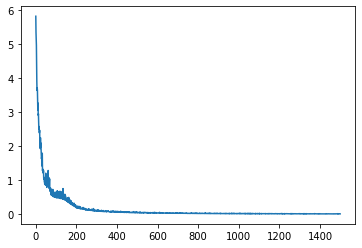

Train F1 score: 1.0
Train Accuracy: 100.00%
Test F1 score: 0.5180500658761529
Test Accuracy: 53.33%
Pred [1, 2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 2]
Actual [1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 2]
['SHOP002', 'SHOP019', 'SHOP023', 'SHOP024', 'SHOP029', 'SHOP030', 'SHOP038', 'SHOP044', 'SHOP046', 'SHOP050', 'SHOP056', 'SHOP061', 'SHOP070', 'SHOP074', 'SHOP076', 'SHOP080', 'SHOP081', 'SHOP087', 'SHOP092', 'SHOP096', 'SHOP097', 'SHOP107', 'SHOP108', 'SHOP114']
[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 2, 0, 0]
.....

Exception ignored in: <function _releaseLock at 0x7f9533920ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


..

Exception ignored in: <function _releaseLock at 0x7f9533920ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


.

KeyboardInterrupt: 

In [83]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(7)


class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=3):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        # self.layers.append(nn.Dropout(0.1))

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


class MLPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


hdims = ([3], [4], [7], [9], [27], [3, 3], [9, 3], [9, 9], [27, 3])
# hdims = [[i] for i in range(2,11)]
for h_dim in hdims:
    train_x_np = selected_X_train.to_numpy()
    y_train_classes = pd.DataFrame(columns=["L", "M", "H"])
    y_train_classes["L"] = selected_y_train.apply(lambda x: 1 if x == 0 else 0)
    y_train_classes["M"] = selected_y_train.apply(lambda x: 1 if x == 1 else 0)
    y_train_classes["H"] = selected_y_train.apply(lambda x: 1 if x == 2 else 0)
    train_y_np = y_train_classes.to_numpy()
    test_x_np = selected_X_test.to_numpy()

    train_dataset = MLPDataset(train_x_np, train_y_np)

    model_class = MultiLayerPerceptron(
        input_size=train_x_np.shape[1], hidden_sizes=h_dim, output_size=3
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_class.parameters(), lr=0.02, momentum=0.9)

    epochs = 1500
    losses = []
    # inputs = torch.from_numpy(train_x_np).float().to(device)
    # labels = torch.from_numpy(train_y_np).float().to(device)
    dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16)

    for epoch in range(epochs):
        train_loss, train_acc = 0, 0
    
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model_class(X)
            loss = criterion(outputs, y)
            train_loss += loss.item() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_class = torch.argmax(y, dim=1)
            train_acc += (y_pred_class == y_class).sum().item()/len(outputs)

        if epoch % (epochs // 40) == 0:
            print(".", end="")

        losses.append(train_loss)

    print("\n", model_class)

    plt.plot(losses)
    plt.show()

    with torch.no_grad():
        y_train_pred = model_class.softmax(
            model_class(torch.from_numpy(train_x_np).float().to(device))
        )
    y_train_pred = y_train_pred.cpu().numpy()
    y_train_pred = np.argmax(y_train_pred, axis=1)

    f1 = f1_score(selected_y_train, y_train_pred, average="macro")
    print("Train F1 score:", f1)

    accuracy = accuracy_score(selected_y_train, y_train_pred) * 100
    print("Train Accuracy: {:.2f}%".format(accuracy))

    test_x_np = torch.from_numpy(test_x_np).float().to(device)
    with torch.no_grad():
        y_pred = model_class.softmax(model_class(test_x_np))
    y_pred = y_pred.cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)

    f1 = f1_score(selected_y_test, y_pred, average="macro")
    print("Test F1 score:", f1)

    accuracy = accuracy_score(selected_y_test, y_pred) * 100
    print("Test Accuracy: {:.2f}%".format(accuracy))

    print("Pred", list(y_pred))
    print("Actual", list(selected_y_test))

    problem_df_ = (
        torch.from_numpy(
            problem_df.drop(columns=["shop_id", "shop_profile"]).to_numpy(
                dtype=np.float32
            )
        )
        .float()
        .to(device)
    )
    with torch.no_grad():
        problem_pred = model_class.softmax(model_class(problem_df_))
    problem_pred = problem_pred.cpu().numpy()
    problem_pred = np.argmax(problem_pred, axis=1)

    print(list(problem_df["shop_id"]))
    print(list(problem_pred))


In [86]:
problem_shops = ['SHOP002', 'SHOP019', 'SHOP023', 'SHOP024', 'SHOP029', 'SHOP030', 'SHOP038', 'SHOP044', 'SHOP046', 'SHOP050', 'SHOP056', 'SHOP061', 'SHOP070', 'SHOP074', 'SHOP076', 'SHOP080', 'SHOP081', 'SHOP087', 'SHOP092', 'SHOP096', 'SHOP097', 'SHOP107', 'SHOP108', 'SHOP114']
problem_preds = [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 2, 0, 0]

problem_dict = {}

for shop_id, pred in zip(problem_shops, problem_preds):
    problem_dict[shop_id] = pred

foostr = "SHOP046,SHOP024,SHOP023,SHOP097,SHOP044,SHOP030,SHOP038,SHOP029,SHOP096,SHOP092,SHOP081,SHOP076,SHOP080,SHOP074,SHOP107,SHOP108,SHOP019,SHOP002,SHOP114,SHOP087,SHOP050,SHOP061,SHOP056,SHOP070"
for shop_id in foostr.split(","):
    print(f"{shop_id},{['Low', 'Moderate', 'High'][problem_dict[shop_id]]}")

print([problem_dict[shop_id] for shop_id in foostr.split(",")])


SHOP046,Low
SHOP024,Low
SHOP023,Low
SHOP097,Moderate
SHOP044,Moderate
SHOP030,Moderate
SHOP038,Low
SHOP029,Moderate
SHOP096,Low
SHOP092,Low
SHOP081,High
SHOP076,Low
SHOP080,Low
SHOP074,High
SHOP107,High
SHOP108,Low
SHOP019,Low
SHOP002,Low
SHOP114,Low
SHOP087,Moderate
SHOP050,Low
SHOP061,Moderate
SHOP056,High
SHOP070,Low
[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 2, 0]
